## Cargar las bibliotecas necesarias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Cargar y limpiar los datos

In [ ]:
def cargar_datos(file_path):
    """
    Carga y limpia los datos desde un archivo Parquet.

    Args:
        file_path (str): Ruta del archivo Parquet.

    Returns:
        pd.DataFrame: DataFrame con los datos limpios.
    """
    df = pd.read_parquet(file_path)
    df = df.rename(columns={'TALLA': 'Talla', 'COLOR': 'Color'})
    return df

file_path = 'Ruta'
df = cargar_datos(file_path)

##Exploración los datos

In [ ]:
def explorar_datos(df):
    """
    Imprime información y estadísticos descriptivos del DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
    """
    print(df.info())
    print(df.describe())
    print(df['Centro'].unique())
    print(df['Material'].unique())
    print(df['Artículo'].unique())
    print(df['Talla'].unique())
    print(df['Color'].unique())
    print(df.head())

explorar_datos(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6462432 entries, 0 to 6462431
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Centro    object 
 1   Año/Mes   object 
 2   Material  object 
 3   Cantidad  float64
 4   Artículo  object 
 5   Talla     object 
 6   Color     object 
dtypes: float64(1), object(6)
memory usage: 345.1+ MB
None
           Cantidad
count  6.462432e+06
mean   9.142154e-01
std    4.007743e-01
min   -1.100000e+01
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    3.000000e+00
['T083' 'FN50' 'T084' 'T049' 'T097' 'FN47' 'FN73' 'T075' 'FN56' 'FN52'
 'FN76' 'FN87' 'T071' 'T090' 'T045' 'T055' 'T026' 'FN65' 'T014' 'FN84'
 'FN59' 'FN54' 'T019' 'B001' 'FN74' 'FN86' 'FN60' 'FN64' 'FN66' 'T016'
 'T080' 'FN89' 'T047' 'FN61' 'FN91' 'T012' 'T035' 'FN67' 'FN92' 'T022'
 'T017' 'FN90' 'FN45' 'FN88' 'T015' 'T037' 'P001' 'T013' 'T024' 'T086'
 'T101' 'T050' 'T036' 'T038' 'T042' 'T044' 'T066' 'T064' 'T057' 'T009'
 'T089' 'FN44' '

##Visualización de la distribución de la cantidad

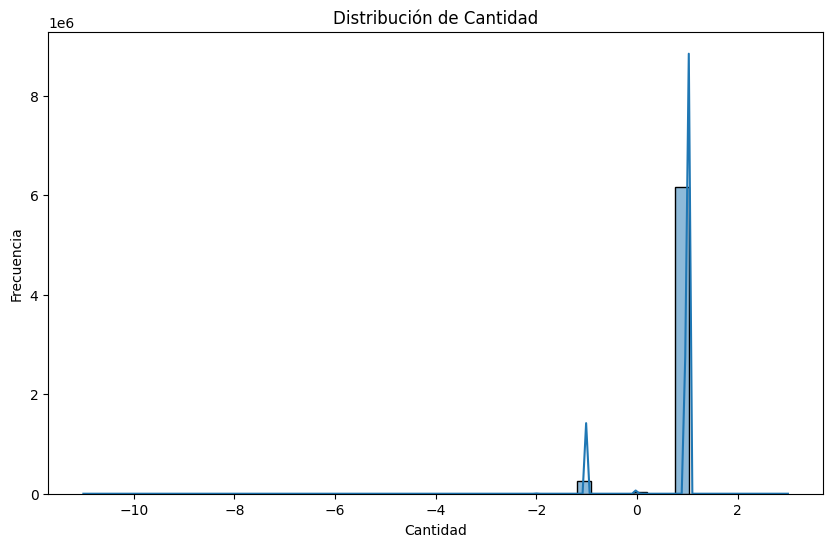

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Cantidad'], bins=50, kde=True)
plt.title('Distribución de Cantidad')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.show()

Al observar la distribución de la cantidad en el conjunto de datos, noto que la barra más alta está alrededor de 1, mientras que hay un notable vacío alrededor de -1. Esto sugiere que la mayoría de las cantidades registradas tienden a ser positivas, con relativamente pocas observaciones con valores negativos

 ## visualizar la distribución de una columna (Tallas) filtrando por un umbral de ventas mayores a 1000 prendas

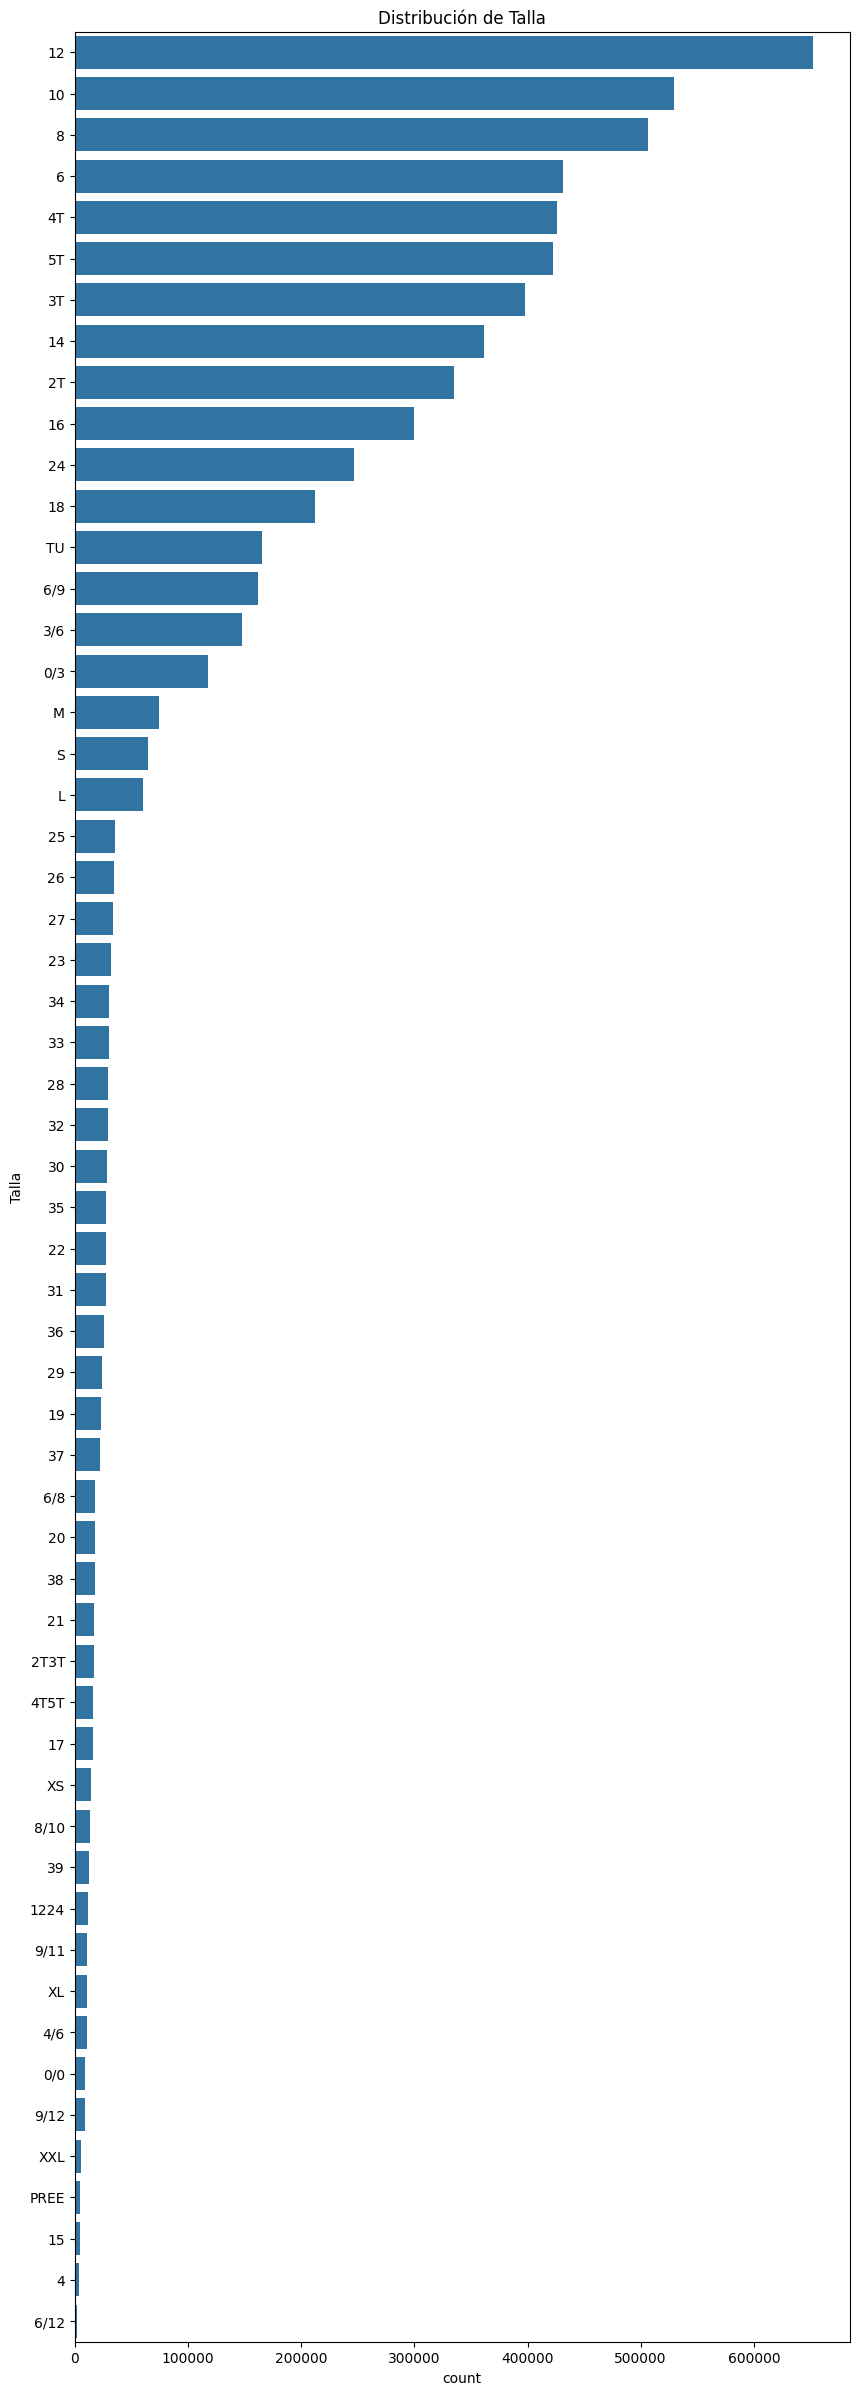

In [ ]:
def visualizar_distribucion(df, columna, umbral):
    """
    Genera un gráfico de la distribución de una columna filtrando por un umbral.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columna (str): Nombre de la columna a visualizar.
        umbral (int): Umbral de frecuencia para filtrar los datos.
    """
    df_filtered = df[df[columna].notna() & (df[columna] != " ")]
    counts = df_filtered[columna].value_counts()
    filtered_index = counts[counts > umbral].index
    filtered_df = df_filtered[df_filtered[columna].isin(filtered_index)]

    plt.figure(figsize=(10, 30))
    sns.countplot(y=filtered_df[columna], order=filtered_index)
    plt.title(f'Distribución de {columna}')
    plt.show()

visualizar_distribucion(df, 'Talla', 1000)



Al visualizar la distribución de las tallas, enfocándome en las tallas 12, 10 y 8 debido a su frecuencia relativamente alta, puedo notar que estas tallas son las más comunes en el conjunto de datos. Este hallazgo sugiere que la mayoría de las observaciones registradas tienen estas tallas, lo que podría ser indicativo de tendencias en la población o preferencias dentro del contexto de los datos.

##Visualización de la distribución por material filtrando ventas mayores a 6000 prendas.

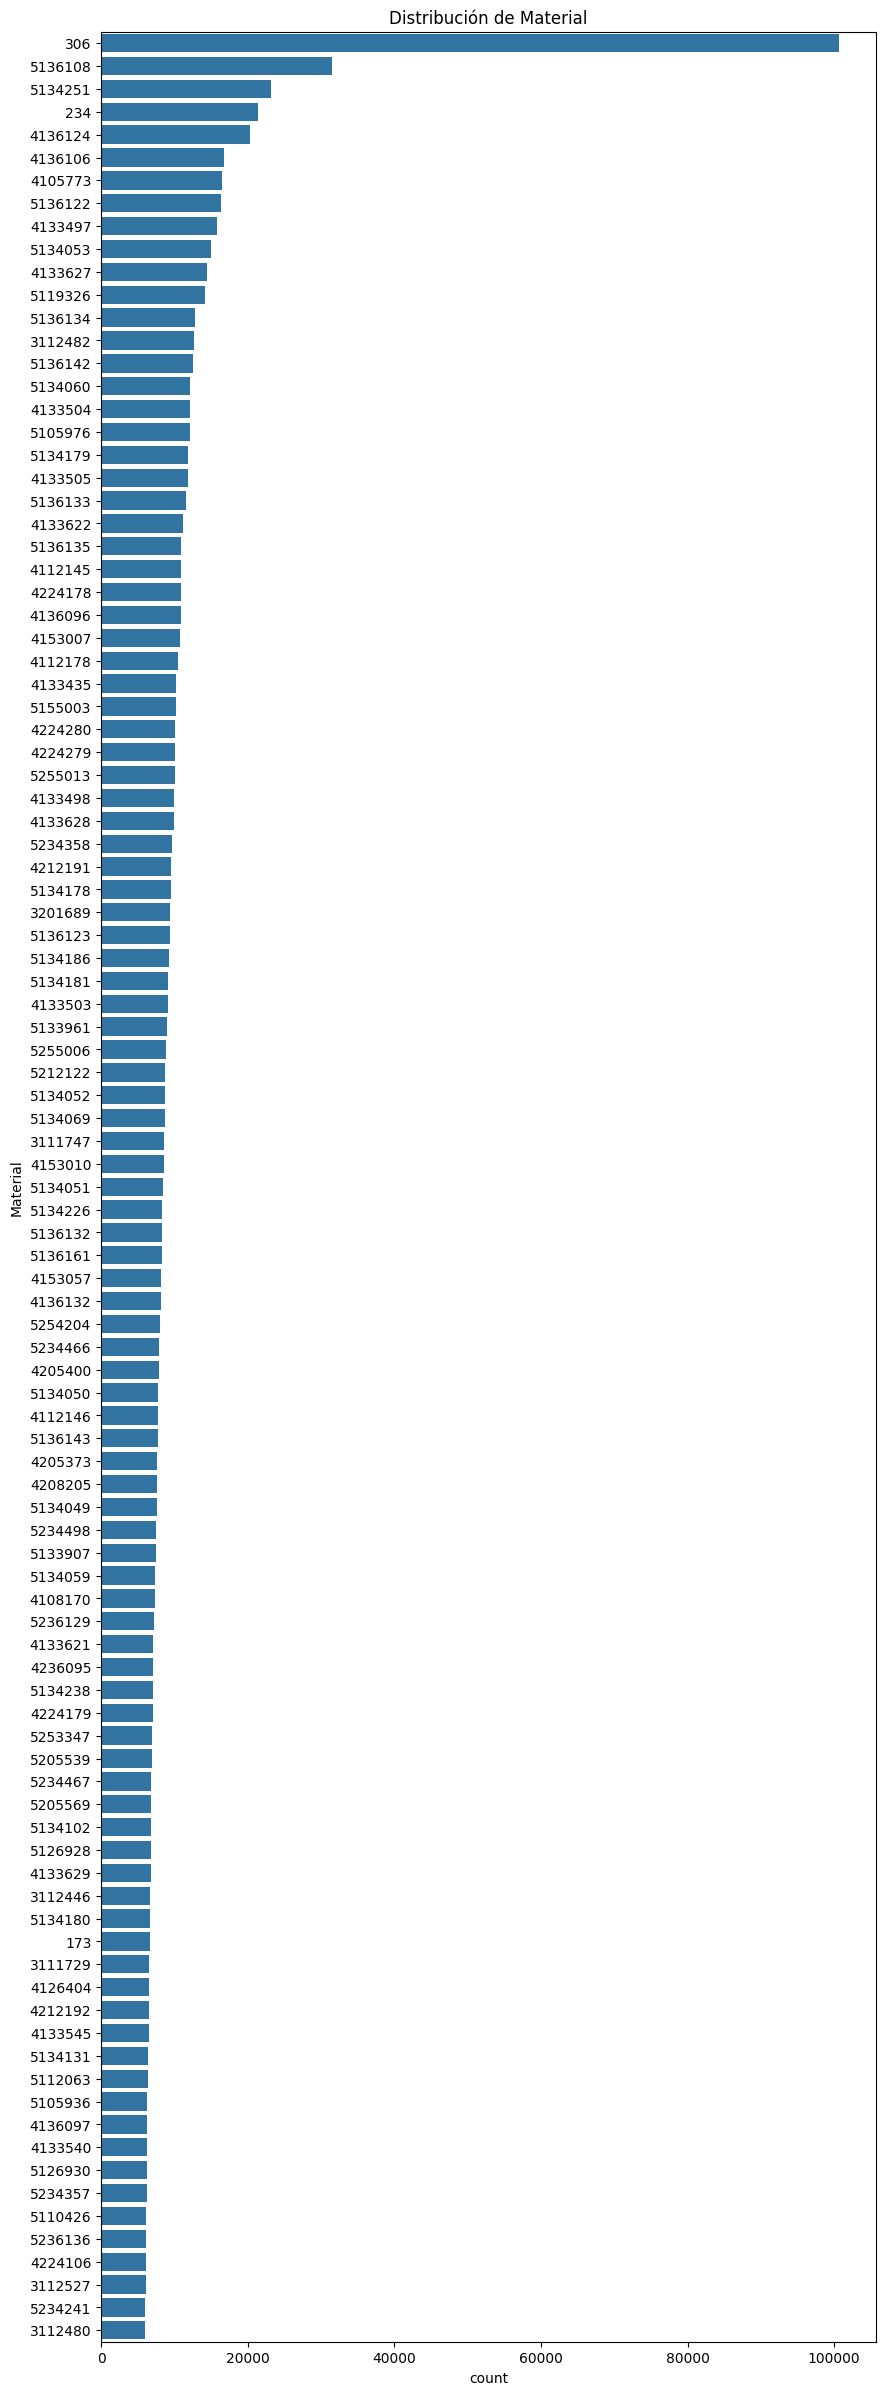

In [ ]:
visualizar_distribucion(df[df['Material'] != ''], 'Material', 6000)

Al analizar la distribución de los materiales, destaco que el material 306 es el más utilizado, con aproximadamente 100,000 prendas, seguido por el material 5136108 con alrededor de 30,000 prendas. Además, observo que hay otros materiales con una distribución más uniforme, con valores cercanos a 10,000 y 20,000 prendas.

Esta conclusión sugiere que existe una disparidad significativa en la frecuencia de uso entre los materiales más comunes y los menos comunes. El hecho de que el material 306 sea tan dominante podría indicar su importancia en el contexto del conjunto de datos o en la producción en general. Por otro lado, los materiales con frecuencias más uniformes podrían ser menos prevalentes o tener un uso más equitativo en comparación con los materiales principales.

##Preparación de datos para evaluar los modelos de Cantidad, generando una copia del dtaframe para realizar modificaciones de colomna y realizar la codificación ordinal

In [ ]:
def preparar_datos(df):
    """
    Prepara los datos para el entrenamiento de los modelos.

    Args:
        df (pd.DataFrame): DataFrame con los datos.

    Returns:
        Tuple: Conjuntos de entrenamiento y prueba.
    """
    df_final = df.copy()
    df_final[['Año', 'Mes']] = df_final['Año/Mes'].str.split('|', expand=True)
    df_final['Año'] = df_final['Año'].astype(int)
    df_final['Mes'] = df_final['Mes'].astype(int)

    label_encoder = LabelEncoder()
    for column in ['Talla', 'Color', 'Centro', 'Artículo', 'Material']:
        df_final[column] = label_encoder.fit_transform(df_final[column])

    df_final = df_final.drop(['Año/Mes'], axis=1)
    X = df_final.drop(['Cantidad'], axis=1)
    y = df_final['Cantidad']
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = preparar_datos(df)


##Función para entrenar y evaluar un modelo de regresión

In [ ]:
def entrenar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo de regresión.

    Args:
        modelo: Modelo de regresión a entrenar.
        X_train (pd.DataFrame): Conjunto de entrenamiento.
        y_train (pd.Series): Etiquetas de entrenamiento.
        X_test (pd.DataFrame): Conjunto de prueba.
        y_test (pd.Series): Etiquetas de prueba.

    Returns:
        Tuple: Predicciones y Error cuadrático medio del modelo.
    """
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    mse = mean_squared_error(y_test, predicciones)
    return predicciones, mse

##Modelo de Regresión Lineal, entrenamiento y evaluación




In [ ]:
linear_reg = LinearRegression()
predicciones_linear, mse_linear = entrenar_modelo(linear_reg, X_train, y_train, X_test, y_test)
print("MSE (Regresión Lineal):", mse_linear)

MSE (Regresión Lineal): 0.15941435263783588


##Modelo de Bosque Aleatorio, entrenamiento y evaluación

In [ ]:
rf_reg = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100)
predicciones_rf, mse_rf = entrenar_modelo(rf_reg, X_train, y_train, X_test, y_test)
print("MSE (Bosque Aleatorio):", mse_rf)


MSE (Bosque Aleatorio): 0.11428118072005294


##Modelo de Gradient Boosting, entrenamiento y evaluación

In [ ]:
gb_reg = GradientBoostingRegressor(random_state=42, max_depth=10, n_estimators=100, learning_rate=0.1)
predicciones_gb, mse_gb = entrenar_modelo(gb_reg, X_train, y_train, X_test, y_test)
print("MSE (Gradient Boosting):", mse_gb)


MSE (Gradient Boosting): 0.11328335007061659


##Modelo de LightGBM, entrenamiento y evaluación

In [ ]:
lgbm_reg = LGBMRegressor(random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
predicciones_lgbm, mse_lgbm = entrenar_modelo(lgbm_reg, X_train, y_train, X_test, y_test)
print("MSE (LightGBM):", mse_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.465985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 5169945, number of used features: 7
[LightGBM] [Info] Start training from score 0.914145
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
MSE (LightGBM): 0.11375573276490004


##Modelo de XGBoost, entrenamiento y evaluación

In [ ]:
xgb_reg = XGBRegressor(random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
predicciones_xgb, mse_xgb = entrenar_modelo(xgb_reg, X_train, y_train, X_test, y_test)
print("MSE (XGBoost):", mse_xgb)

MSE (XGBoost): 0.11388811484266859


##Comparación de resultados

              Modelo       MSE
0   Regresión Lineal  0.159414
1   Bosque Aleatorio  0.114281
2           LightGBM  0.113756
3            XGBoost  0.113888
4  Gradient Boosting  0.113283


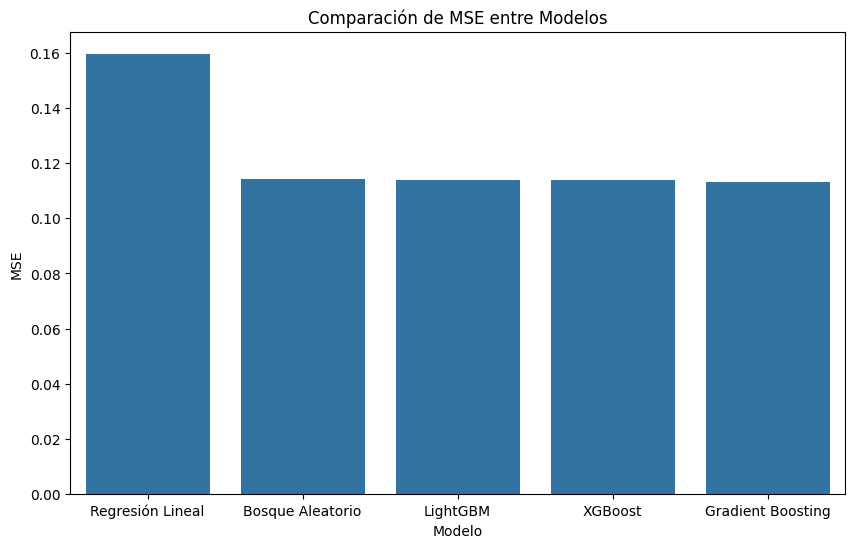

In [ ]:
resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Bosque Aleatorio', 'LightGBM', 'XGBoost', 'Gradient Boosting'],
    'MSE': [mse_linear, mse_rf, mse_lgbm, mse_xgb, mse_gb]
})

print(resultados)

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='MSE', data=resultados)
plt.title('Comparación de MSE entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.show()

Al analizar los resultados, destaco que el modelo LightGBM no solo logró un MSE bajo, sino que también se destacó por su eficiencia en el tiempo de ejecución. Aunque los modelos de Bosque Aleatorio, XGBoost y Gradient Boosting también mostraron un rendimiento similar en términos de precisión predictiva, el modelo LightGBM se distinguió al ser el más rápido en ejecutarse.

Esta combinación de precisión y eficiencia hace que el modelo LightGBM sea una opción atractiva y práctica para aplicaciones en tiempo real o situaciones donde se requiere un procesamiento rápido de grandes conjuntos de datos. Su capacidad para ofrecer resultados precisos en un tiempo reducido lo convierte en una herramienta valiosa para aplicaciones prácticas donde el rendimiento computacional es crucial.

##Histograma de distribución de errores para los cinco modelos

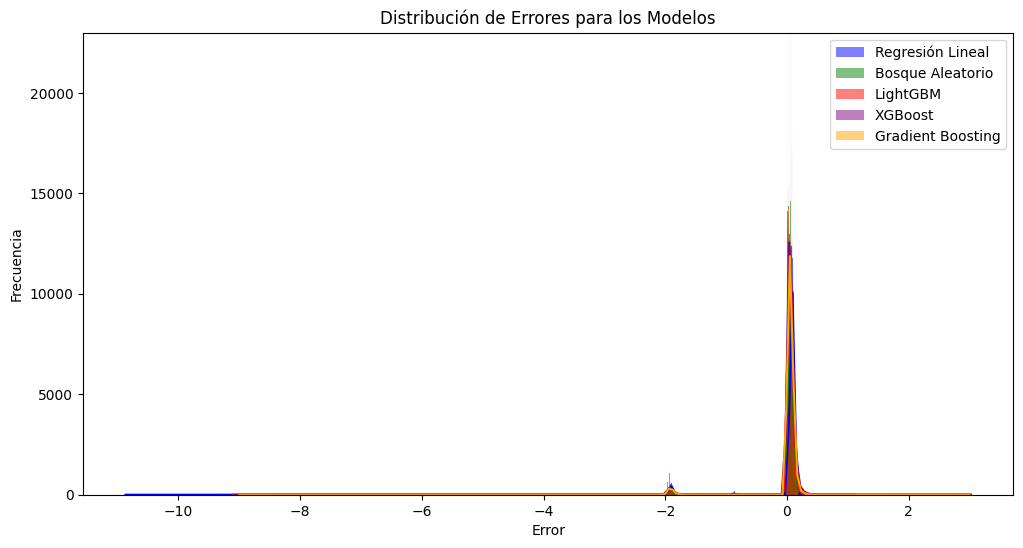

In [ ]:
errores_linear = y_test - predicciones_linear
errores_rf = y_test - predicciones_rf
errores_lgbm = y_test - predicciones_lgbm
errores_xgb = y_test - predicciones_xgb
errores_gb = y_test - predicciones_gb

plt.figure(figsize=(12, 6))
sns.histplot(errores_linear, kde=True, color='blue', label='Regresión Lineal', alpha=0.5)
sns.histplot(errores_rf, kde=True, color='green', label='Bosque Aleatorio', alpha=0.5)
sns.histplot(errores_lgbm, kde=True, color='red', label='LightGBM', alpha=0.5)
sns.histplot(errores_xgb, kde=True, color='purple', label='XGBoost', alpha=0.5)
sns.histplot(errores_gb, kde=True, color='orange', label='Gradient Boosting', alpha=0.5)

plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de Errores para los Modelos')

plt.ylim(0, 23000)
plt.show()


 La distribución de errores muestra que los modelos generalmente tienen una precisión decente, con la mayoría de las predicciones cerca del valor real (error alrededor de 1). Sin embargo, hay áreas donde los modelos tienen dificultades, como los errores entre 9000 y 15000, que pueden necesitar una atención especial para mejorar el rendimiento del modelo en esos casos. En cuanto al pequeño pico en el valor -2, podría ser un área de interés para investigar más a fondo y comprender por qué los modelos tienen dificultades con esos casos específicos.